In [82]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [29]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'],nrows=50000)

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   4  Estou contente com a compra entrega rápida o ú...
1                   4  Por apenas R$1994.20,eu consegui comprar esse ...
2                   4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                   4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                   5  A entrega foi no prazo, as americanas estão de...
...               ...                                                ...
49995               5  É com muito prazer que avalio esse produto! Si...
49996               4  é uma bicicleta bonita e bonita, com o tempo v...
49997               5  O produto chegou 8 dias antes do prazo e em pe...
49998               2  O produto até chegou dentro do prazo, só que e...
49999               5  Excelente! Superou minhas expectativas! Ótimo ...

[50000 rows x 2 columns]>


In [30]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [31]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [32]:
print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   4  contente compra entrega rapida unico problema ...
1                   4        apenas consegui comprar lindo copo acrilico
2                   4  supera agilidade praticidade outras panelas el...
3                   4          filho amou parece verdade tantos detalhes
4                   5  entrega prazo americanas estao parabens smart ...
...               ...                                                ...
49995               5  prazer avalio produto simplesmente maravilhoso...
49996               4  bicicleta bonita bonita tempo veremos durabili...
49997               5    produto chegou dias antes prazo perfeito estado
49998               2  produto ate chegou dentro prazo so espero nunc...
49999               5  excelente superou expectativas otimo desempenh...

[50000 rows x 2 columns]>


In [33]:
b2wCorpus.overall_rating .value_counts().sort_index()

1     9538
2     3179
3     6121
4    12529
5    18633
Name: overall_rating, dtype: int64

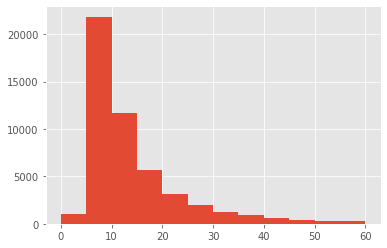

49169


In [34]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [35]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of        overall_rating                                        review_text
0                   1  nao chegou tempo esprando issso to arrependido...
1                   1  nao veio original vaio falsificado lacre ta ta...
2                   1  semana instalado eletricista cairam enfeite la...
3                   4  recurso utilizado personagem denzel washington...
4                   5  gostamos fritadeira esperamos dure bastante po...
...               ...                                                ...
49995               5  entrega feita rapida nenhum estragado jogo per...
49996               2  aparelho consegue medir humidade ar tao barato...
49997               3  acordo especificacoes valor nao deve ser tao a...
49998               5  produto qualidade adequado pratica atividades ...
49999               3  produto bom porem nao boa impressao cara pois ...

[50000 rows x 2 columns]>


In [36]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [37]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [38]:
b2wCorpus.shape

(50000, 3)

In [39]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 5].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [40]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [41]:
b2wCorpus.shape

(47628, 3)

In [42]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [43]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 428, 104, 0, 199898, 1570, 18943, 290, ...",10
1,0,"[7804, 930, 1100, 111044, 46145, 58187, 10883,...",13
2,3,"[1469, 1336, 1140, 48141, 2177, 14596, 199606,...",49
3,4,"[14578, 127381, 4526, 35622, 678, 117, 153099,...",9
4,2,"[902, 226, 2697, 102, 9916, 307, 2648, 3384, 2...",22


In [44]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [45]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [46]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 428, 104, 0, 199898, 1570, 18943, 290, ...",10
1,0,"[7804, 930, 1100, 111044, 46145, 58187, 10883,...",13
2,3,"[1469, 1336, 1140, 48141, 2177, 14596, 199606,...",49
3,4,"[14578, 127381, 4526, 35622, 678, 117, 153099,...",9
4,2,"[902, 226, 2697, 102, 9916, 307, 2648, 3384, 2...",22


In [47]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [48]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [49]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
38029,2,"[44608, 12709, 5137, 17299, 784, 106, 4197, 51...",50
45895,0,"[13478, 31505, 106, 10071, 9968, 1705, 1812, 1...",50
31686,0,"[239, 362, 612, 902, 9735, 5437, 169, 1806, 13...",50
3369,0,"[45850, 10570, 0, 8567, 4339, 17715, 14762, 86...",50
19700,0,"[7804, 41933, 0, 18874, 110, 3093, 902, 8201, ...",50


In [50]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
29811               4  [13218, 930, 88, 0, 9697, 8837, 0, 902, 1229, ...   50
43720               0  [26382, 20907, 5547, 30029, 6689, 293, 61, 252...   50
36693               1  [930, 10185, 2420, 502, 39, 548, 7968, 930, 37...   50
16575               0  [902, 0, 7804, 2901, 0, 5841, 1349, 134819, 94...   50
34877               1  [902, 44379, 0, 15035, 38352, 330, 109923, 281...   50
...               ...                                                ...  ...
33274               4  [2104, 902, 532, 51890, 22522, 0, 0, 0, 0, 0, ...    5
40639               3  [20465, 3690, 11352, 54465, 34671, 0, 0, 0, 0,...    5
6966                2  [6376, 902, 2697, 127, 0, 0, 0, 0, 0, 0, 0, 0,...    5
2452                3  [6376, 11759, 3690, 22522, 88, 0, 0, 0, 0, 0, ...    5
40468               2  [566, 1957, 502, 3851, 75489, 0, 0, 0, 0, 0, 0...    5

[4762 rows x 3 columns]>

In [51]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
21300               4  [1664, 728, 304, 2759, 345, 297, 2499, 1761, 9...   50
34341               0  [9735, 12689, 86, 20820, 2499, 1761, 141, 86, ...   50
29978               2  [502, 3841, 709, 39, 18982, 167, 265, 587, 153...   50
24557               1  [20017, 0, 0, 10797, 7437, 10761, 7555, 96, 0,...   50
31406               0  [902, 428, 321, 566, 17382, 930, 902, 2110, 10...   50
...               ...                                                ...  ...
40776               3  [962, 600, 122, 321, 12153, 0, 0, 0, 0, 0, 0, ...    5
39696               1  [3699, 7804, 175685, 3448, 0, 0, 0, 0, 0, 0, 0...    5
26849               2  [902, 428, 566, 8512, 0, 0, 0, 0, 0, 0, 0, 0, ...    5
5569                4  [2104, 902, 3615, 532, 11816, 0, 0, 0, 0, 0, 0...    5
15008               3  [902, 7126, 70, 187, 2898, 0, 0, 0, 0, 0, 0, 0...    5

[11908 rows x 3 columns]>

In [52]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [54]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()


38029    2
45895    0
31686    0
3369     0
19700    0
        ..
9693     0
29474    3
25369    4
4467     4
18215    4
Name: overall_rating, Length: 30958, dtype: int64


numpy.ndarray

In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(24, dropout=0.1, return_sequences=True))
model.add(keras.layers.LSTM(32, dropout=0.1))
model.add(keras.layers.Dense(32, activation='elu'))
model.add(keras.layers.Dense(5, activation='softmax'))
# opt = tf.keras.optimizers.SGD(learning_rate=.5, momentum=.5)
opt = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val)
)

Epoch 1/50
1935/1935 [==============================] - 46s 24ms/step - loss: 1.2566 - accuracy: 0.4732 - val_loss: 1.1787 - val_accuracy: 0.5046
Epoch 2/50
1935/1935 [==============================] - 45s 23ms/step - loss: 1.1703 - accuracy: 0.5039 - val_loss: 1.1450 - val_accuracy: 0.5128
Epoch 3/50
1935/1935 [==============================] - 44s 23ms/step - loss: 1.1392 - accuracy: 0.5113 - val_loss: 1.1326 - val_accuracy: 0.5202
Epoch 4/50
1935/1935 [==============================] - 44s 23ms/step - loss: 1.1232 - accuracy: 0.5170 - val_loss: 1.0955 - val_accuracy: 0.5233
Epoch 5/50
1935/1935 [==============================] - 44s 23ms/step - loss: 1.1107 - accuracy: 0.5183 - val_loss: 1.1031 - val_accuracy: 0.5220
Epoch 6/50
1935/1935 [==============================] - 45s 23ms/step - loss: 1.0988 - accuracy: 0.5207 - val_loss: 1.0784 - val_accuracy: 0.5317
Epoch 7/50
1935/1935 [==============================] - 45s 23ms/step - loss: 1.0893 - accuracy: 0.5245 - val_loss: 1.0726 -

In [ ]:

#Tokenizando
vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )
vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)